Notebook para verificar si hay diferencias significativas entre las medias de ADR entre los principales Estados de origen de los clientes

*Importar las librerías*


In [ ]:
import pandas as pd 

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro, levene

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Cargar los dataset (Ocupaciones completo y serie de tiempo por Edo)

In [75]:
ocupaciones = pd.read_csv("../data/ia_ocupaciones_gigante_limpia2.csv").sort_values(
    "Fecha_hoy",
    ascending=True,
)
print(ocupaciones.shape)
ocupaciones.head()


(2114464, 17)


,Fecha_hoy,ID_Entidad_Fed,ID_Tipo_Habitacion,ID_canal,ID_edificio,ID_Segmento_Mercado,ID_Segmento_Alterno,ID_Segmento_Comp,moneda_cve,ID_empresa,ID_Empresa2,ing_hab,cto_noc,ADR,num_men,num_adu,TREVPEC
663394,2020-11-01,Otro,6,2,2.0,1.0,Otro,Otro,1.0,1.0,1.0,10511.590000,5.0,2102.318000,5.0,11.0,955.599091
663101,2020-11-01,173,Otro,3,2.0,6.0,17.0,34.0,2.0,1.0,1.0,4256.097675,1.0,4256.097675,3.0,2.0,45491.300000
663102,2020-11-01,173,6,3,2.0,6.0,17.0,34.0,2.0,1.0,1.0,1210.721804,1.0,1210.721804,1.0,2.0,12940.800000
663103,2020-11-01,173,17,3,3.0,6.0,15.0,32.0,1.0,1.0,7.0,1890.750000,1.0,1890.750000,0.0,2.0,945.375000
663104,2020-11-01,173,17,3,3.0,6.0,17.0,34.0,1.0,1.0,7.0,2055.020000,1.0,2055.020000,0.0,2.0,1027.510000


In [12]:


ocupaciones_TS = pd.read_excel("../data/ocupaciones_time_series_by_entidad.xlsx").sort_values(
    "Fecha_hoy",
    ascending=True,
)

ocupaciones_TS.head()

,Fecha_hoy,ID_Entidad_Fed,ing_hab,cto_noc,ADR,num_men,num_adu,TREVPEC,tasa_ocupacion
0,2020-11-01,Otro,8.154449e+04,36.0,50214.973902,28.0,74.0,2.703952e+05,0.010033
1,2020-11-01,173,1.561952e+06,800.0,760723.172391,352.0,1598.0,4.289819e+06,0.222965
2,2020-11-01,294,4.513085e+04,20.0,45130.854144,6.0,38.0,2.596194e+05,0.005574
3,2020-11-01,48,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000
4,2020-11-01,5,1.539729e+04,6.0,15397.288134,6.0,12.0,8.352593e+04,0.001672


# Encontrar si hay diferencia significativa

Entre la media de TREVPEC por estado de origen de los clientes:

---




## 1. Calcular las medias


In [76]:
# Remove the rows where 'cto_noc' is 0
ocupaciones=ocupaciones[ocupaciones['cto_noc'] !=0 ]
ocupaciones=ocupaciones[ocupaciones['ing_hab'] !=0 ]
ocupaciones=ocupaciones[ocupaciones['ing_hab'] >1 ]
print(ocupaciones.shape)
topomeanADR=ocupaciones.groupby('ID_Entidad_Fed')['TREVPEC'].mean().reset_index()
# change the name of the column to 'Fecha_hoy' for consistency
topcuenta=ocupaciones.groupby('ID_Entidad_Fed')["Fecha_hoy"].count()
topcuenta.rename('Count', inplace=True) 

merged_df = pd.merge(topomeanADR, topcuenta, on='ID_Entidad_Fed', how='inner')
merged_df.sort_values(by='Count', ascending=False, inplace=True)
merged_df

(1056041, 17)


,ID_Entidad_Fed,TREVPEC,Count
5,Otro,16610.858874,546696
0,173,12046.764446,241343
2,294,19301.584876,82096
3,48,15648.270076,81175
4,5,13953.287377,60661
1,253,16573.033826,44070


De acuerdo con el groupby, parece ser que la media de gasto por cliente es diferente entre los distintos estados (o países), habrá que hacer una prueba ANOVA para comprobar este supuesto

## 2. Realizar el análsis anova

In [81]:
df_Anova = ocupaciones[['ID_Entidad_Fed','TREVPEC']]
# Drop the rows with ID_Entidad_Fed = 'otro'
df_Anova = df_Anova[df_Anova['ID_Entidad_Fed'] != 'Otro']


,ID_Entidad_Fed,TREVPEC
663101,173,45491.300
663102,173,12940.800
663103,173,945.375
663104,173,1027.510
663105,173,860.205


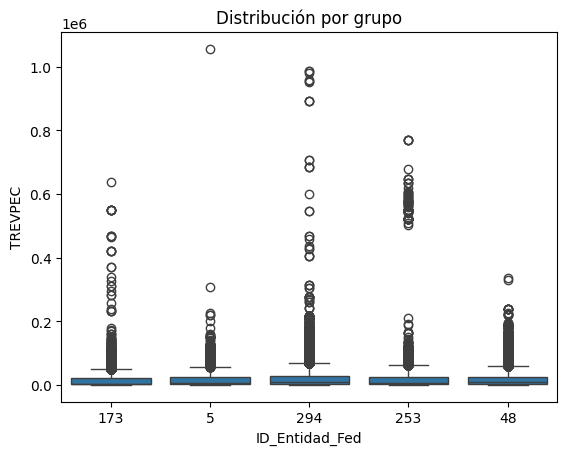

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='ID_Entidad_Fed', y='TREVPEC', data=df_Anova)
plt.title("Distribución por grupo")
plt.show()

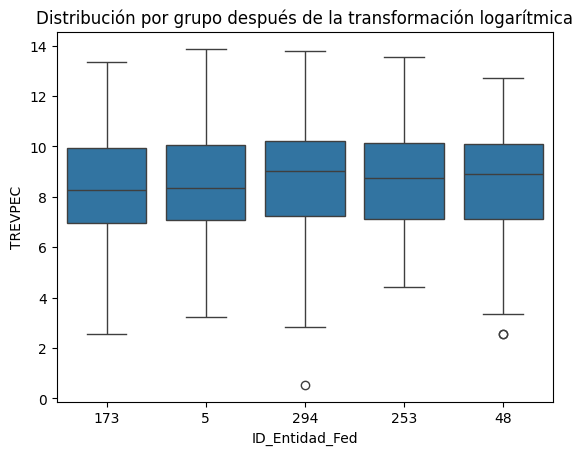

In [83]:
df_Anova['TREVPEC'] = np.log(df_Anova['TREVPEC'])
# Check the distribution of the data after log transformation
sns.boxplot(x='ID_Entidad_Fed', y='TREVPEC', data=df_Anova)
plt.title("Distribución por grupo después de la transformación logarítmica")
plt.show()

In [84]:
from scipy.stats import shapiro, levene

# Normalidad por grupo
for grupo in df_Anova['ID_Entidad_Fed'].unique():
    stat, p = shapiro(df_Anova[df_Anova['ID_Entidad_Fed'] == grupo]['TREVPEC'])
    print(f"Grupo {grupo} - p normalidad: {p:.4f}")

# Homogeneidad de varianzas (Levene)
stat, p = levene(
    df_Anova[df_Anova['ID_Entidad_Fed'] == '173']['TREVPEC'],
    df_Anova[df_Anova['ID_Entidad_Fed'] == '294']['TREVPEC'],
    df_Anova[df_Anova['ID_Entidad_Fed'] == '48']['TREVPEC'],
    df_Anova[df_Anova['ID_Entidad_Fed'] == '5']['TREVPEC'],
    df_Anova[df_Anova['ID_Entidad_Fed'] == '253']['TREVPEC']
)
print(f"Levene - p homogeneidad de varianzas: {p:.4f}")

d:\claseMreporeto\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 241343.
  res = hypotest_fun_out(*samples, **kwds)
d:\claseMreporeto\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 60661.
  res = hypotest_fun_out(*samples, **kwds)
d:\claseMreporeto\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 82096.
  res = hypotest_fun_out(*samples, **kwds)
d:\claseMreporeto\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44070.
  res = hypotest_fun_out(*samples, **kwds)


Grupo 173 - p normalidad: 0.0000
Grupo 5 - p normalidad: 0.0000
Grupo 294 - p normalidad: 0.0000
Grupo 253 - p normalidad: 0.0000


d:\claseMreporeto\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 81175.
  res = hypotest_fun_out(*samples, **kwds)


Grupo 48 - p normalidad: 0.0000
Levene - p homogeneidad de varianzas: 0.0312


In [86]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

modelo = ols('TREVPEC ~ ID_Entidad_Fed', data=df_Anova).fit()
anova = sm.stats.anova_lm(modelo, typ=2)
print(anova)

                      sum_sq        df            F  PR(>F)
ID_Entidad_Fed  1.293988e+04       4.0  1318.558826     0.0
Residual        1.249621e+06  509340.0          NaN     NaN


Existe diferencia significativa con un 95% de confianza

In [88]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(df_Anova['TREVPEC'], df_Anova['ID_Entidad_Fed'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   173    253   0.2701   0.0   0.248  0.2922   True
   173    294   0.4193   0.0  0.4021  0.4366   True
   173     48   0.2528   0.0  0.2355  0.2701   True
   173      5    0.115   0.0  0.0956  0.1344   True
   253    294   0.1492   0.0   0.124  0.1744   True
   253     48  -0.0173 0.335 -0.0426   0.008  False
   253      5  -0.1551   0.0 -0.1819 -0.1284   True
   294     48  -0.1665   0.0 -0.1877 -0.1454   True
   294      5  -0.3043   0.0 -0.3272 -0.2814   True
    48      5  -0.1378   0.0 -0.1607 -0.1149   True
---------------------------------------------------


Se demuestra con un 95% que la media de gasto por cliente es diferente entre ID_Entidad_Fed

# Mostrar la tendencia anual de los distintos grupos

In [94]:
# Select a subset of the DataFrame with only the top 5 ID_Entidad_Fed
subset_df = ocupaciones[ocupaciones['ID_Entidad_Fed'].isin(merged_df['ID_Entidad_Fed'].tail(5))]

In [95]:
## Add the column of month to the DataFrame
subset_df['Fecha_hoy'] = pd.to_datetime(subset_df['Fecha_hoy'])
subset_df['month'] = subset_df['Fecha_hoy'].dt.month
subset_df['year'] = subset_df['Fecha_hoy'].dt.year
# Group by month and year, and calculate the mean of ADR
monthly_mean_adr = subset_df.groupby(['year', 'month', 'ID_Entidad_Fed'])['ADR'].mean().reset_index()

C:\Users\angel\AppData\Local\Temp\ipykernel_12424\3307615131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Fecha_hoy'] = pd.to_datetime(subset_df['Fecha_hoy'])
C:\Users\angel\AppData\Local\Temp\ipykernel_12424\3307615131.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['month'] = subset_df['Fecha_hoy'].dt.month
C:\Users\angel\AppData\Local\Temp\ipykernel_12424\3307615131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

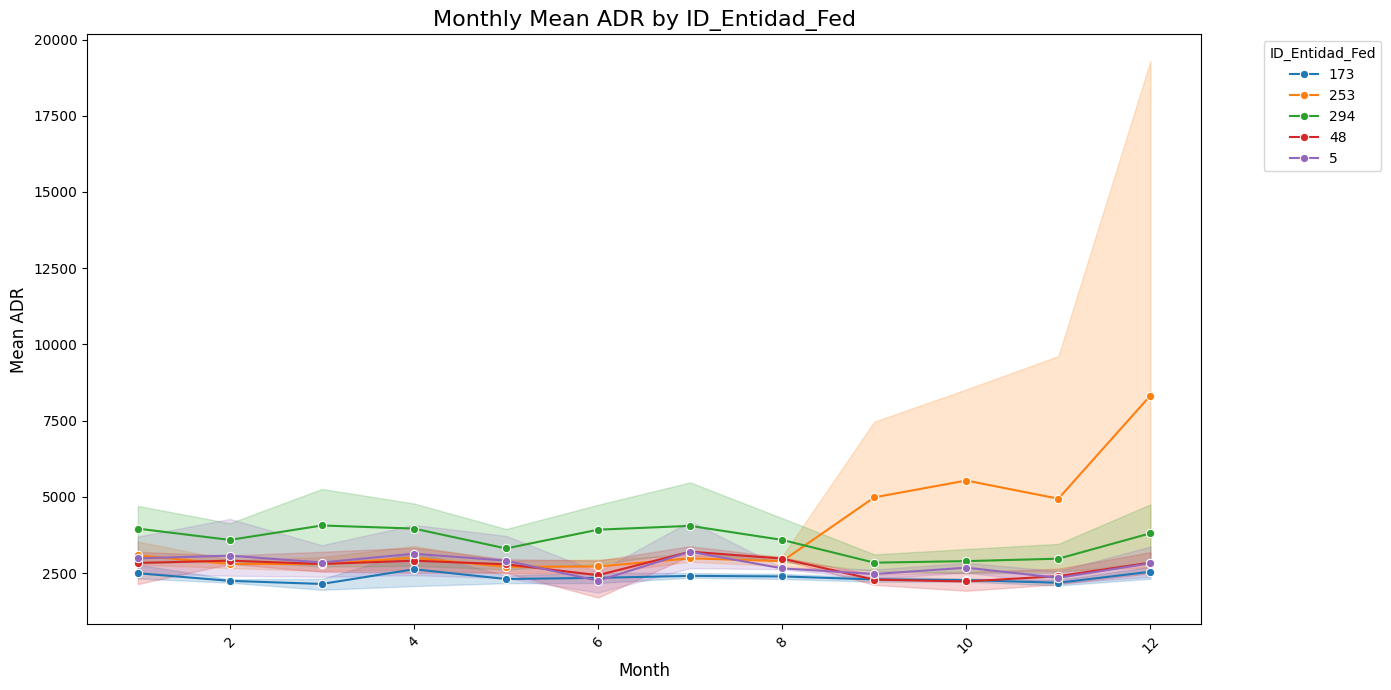

In [96]:
# Graph the monthly mean ADR for each ID_Entidad_Fed
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_mean_adr, x='month', y='ADR', hue='ID_Entidad_Fed', marker='o')
plt.title('Monthly Mean ADR by ID_Entidad_Fed', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean ADR', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='ID_Entidad_Fed', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

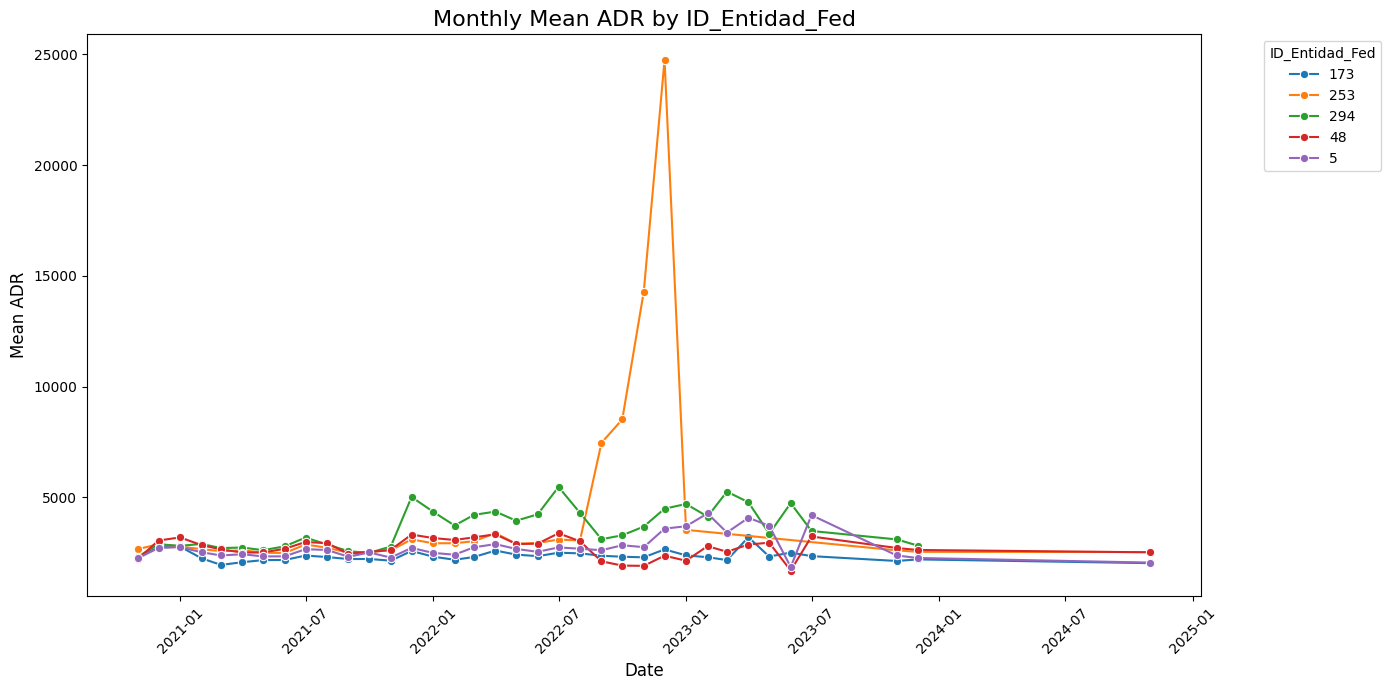

In [97]:
# The same plot, but with year and month as a single datetime column
monthly_mean_adr['date'] = pd.to_datetime(monthly_mean_adr[['year', 'month']].assign(day=1))
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_mean_adr, x='date', y='ADR', hue='ID_Entidad_Fed', marker='o')
plt.title('Monthly Mean ADR by ID_Entidad_Fed', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean ADR', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='ID_Entidad_Fed', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Checar datos atípicos, en especial diciembre 2012